In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import tqdm
from pyarrow import dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.losses import SparseCategoricalCrossentropy

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
        
from helpers import OctantClasses, SphericalManipulations
from helpers import SphericalExponentialActivationStable
from helpers import get_model_predictions

/home/hans/.local/share/virtualenvs/py3_tensorflow-zdenXWfU/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2022-08-11 17:27:59.193641: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-11 17:27:59.869120: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-11 17:27:59.891120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 17:27:59.891261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
cor

In [3]:
bp = '/home/hans/Projects/tensorflow/kaggle/icecube/'
geometry = np.load(bp+'geometry.npy')
flat_features = np.load(bp+"flat_features.npy")
y_orig = np.load(bp+"labels.npy")
y = y_orig

print(flat_features.shape, y.shape)

(100000, 10, 6) (100000, 2)


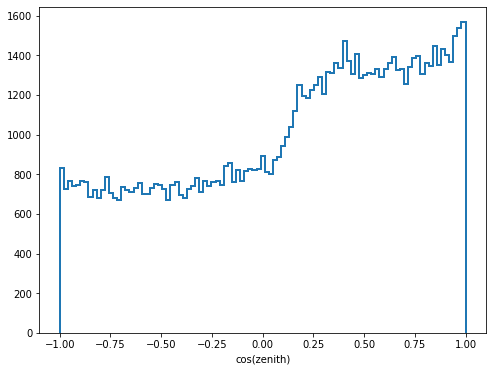

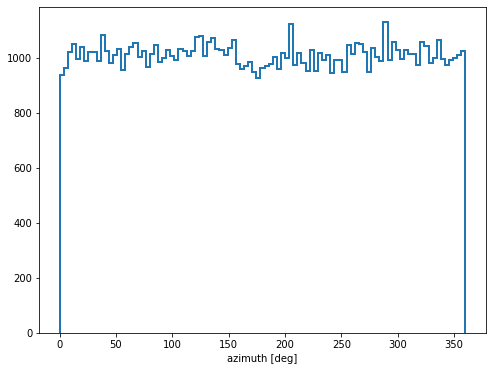

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.hist(np.cos(y[:,1]), bins=np.linspace(-1, 1, 100), histtype='step', lw=2)
ax.set_xlabel('cos(zenith)')
plt.savefig('zenith.png', dpi=300)

fig = plt.figure(figsize=(8,6 ))
ax = plt.subplot()
ax.hist(np.rad2deg(y[:,0]), bins=np.linspace(0, 360, 100), histtype='step', lw=2)
ax.set_xlabel('azimuth [deg]')
plt.savefig('azimuth.png', dpi=300)

In [6]:
# preparte inference targets
octc = OctantClasses()
sphm = SphericalManipulations()

# convert azi, zen to absolut values y1, y2, y3 and 
# sparse representation of sign class (e.g. -,+,-)
y_signs, y_abs = sphm.angles_to_cartesian_absvals_and_signs(y)
classes = octc.signs_to_classes(y_signs)

# put together targets.
targets = np.column_stack([y_abs, classes])
print("targets consist of 3 absolute values. and one class id.")
print(targets)
print("3 absolute values are L2 normalized.")
print(np.sum(targets[:,:-1]**2, axis=1))

targets consist of 3 absolute values. and one class id.
[[0.19747805 0.55071364 0.81099748 3.        ]
 [0.87267793 0.02947194 0.48740603 6.        ]
 [0.80096507 0.34077113 0.49227025 2.        ]
 ...
 [0.26611318 0.06958545 0.96142688 0.        ]
 [0.64717514 0.33840119 0.6831171  4.        ]
 [0.15649872 0.31381351 0.93649839 7.        ]]
3 absolute values are L2 normalized.
[1. 1. 1. ... 1. 1. 1.]


In [7]:
# normalize inputs
mu, std = np.mean(flat_features, axis=0), np.std(flat_features, axis=0)
x = (flat_features - mu) / std

In [8]:
# train test splits
test_size = 0.2
random_state = 42

# get first train, test split of original true azi, zen parameters
x_train, x_test, y_orig_train, y_orig_test = train_test_split(x, y_orig, test_size=test_size, random_state=random_state, shuffle=True)

# now do train, test split for actual training, i.e. targets
x_train, x_test, y_train, y_test = train_test_split(x, targets, test_size=test_size, random_state=random_state, shuffle=True)
# split targets into absvals and signs
y_train_absvals, y_train_signs = y_train[:, :-1], y_train[:, -1]
y_test_absvals, y_test_signs = y_test[:, :-1], y_test[:, -1]

In [9]:
# create custom activation layer (spherical exponential map)
SEAS = SphericalExponentialActivationStable(name='absvals')

# build model
inp = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Flatten()(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)

# branch 1 (3 absolute value components)
y = tf.keras.layers.Dense(50, activation="relu")(x)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(50, activation="relu")(y)
y = tf.keras.layers.Dense(3, activation="linear")(y)
out1 = SEAS(y)

# branch 2  (8 classes)
z = tf.keras.layers.Dense(50, activation="relu")(x)
z = tf.keras.layers.BatchNormalization()(z)
z = tf.keras.layers.Dense(50, activation="relu")(z)
out2 = tf.keras.layers.Dense(8, activation="linear", name='signs')(z)


model = tf.keras.Model(inputs=[inp], outputs=[out1, out2])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 60)           0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60)           240         flatten[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           3050        batch_normalization[0][0]        
_______________________________________________________________________________________

2022-08-11 17:30:23.376212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 17:30:23.399457: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3094370000 Hz
2022-08-11 17:30:23.399985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5597f5cc4110 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-11 17:30:23.399997: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-11 17:30:23.454450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

In [10]:
# create losses 
# classification of octant (predict logits for stability)
cross_entropy = SparseCategoricalCrossentropy(from_logits=True)

# cosine similarity of absolute values
cosine_loss = CosineSimilarity(axis=1)

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss={'absvals': cosine_loss, 'signs': cross_entropy},
              metrics={'signs':'acc'}, loss_weights=[0.9, 0.1])

# fit model
outputs_train = {'absvals': y_train_absvals, 'signs': y_train_signs}
outputs_test = {'absvals': y_test_absvals, 'signs': y_test_signs}
history = model.fit(x_train, outputs_train, epochs=100, batch_size=1024, 
                    verbose=True, validation_data=(x_test, outputs_test))

Epoch 1/100
15/79 [====>.........................] - ETA: 0s - loss: -0.5678 - absvals_loss: -0.8541 - signs_loss: 2.0092 - signs_acc: 0.2362

2022-08-11 17:30:35.743965: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


79/79 [==============================] - 1s 7ms/step - loss: -0.6188 - absvals_loss: -0.8827 - signs_loss: 1.7562 - signs_acc: 0.3392 - val_loss: -0.6323 - val_absvals_loss: -0.8911 - val_signs_loss: 1.6966 - val_signs_acc: 0.3530
Epoch 2/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6542 - absvals_loss: -0.8999 - signs_loss: 1.5578 - signs_acc: 0.4132 - val_loss: -0.6469 - val_absvals_loss: -0.8980 - val_signs_loss: 1.6129 - val_signs_acc: 0.3977
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6617 - absvals_loss: -0.9035 - signs_loss: 1.5142 - signs_acc: 0.4294 - val_loss: -0.6517 - val_absvals_loss: -0.9024 - val_signs_loss: 1.6043 - val_signs_acc: 0.4051
Epoch 4/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6666 - absvals_loss: -0.9058 - signs_loss: 1.4860 - signs_acc: 0.4398 - val_loss: -0.6578 - val_absvals_loss: -0.9042 - val_signs_loss: 1.5599 - val_signs_acc: 0.4173
Epoch 5/100
79/79 [=====================

Epoch 35/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6849 - absvals_loss: -0.9134 - signs_loss: 1.3719 - signs_acc: 0.4798 - val_loss: -0.6617 - val_absvals_loss: -0.9045 - val_signs_loss: 1.5231 - val_signs_acc: 0.4453
Epoch 36/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6852 - absvals_loss: -0.9137 - signs_loss: 1.3722 - signs_acc: 0.4796 - val_loss: -0.6627 - val_absvals_loss: -0.9065 - val_signs_loss: 1.5310 - val_signs_acc: 0.4475
Epoch 37/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6857 - absvals_loss: -0.9137 - signs_loss: 1.3665 - signs_acc: 0.4821 - val_loss: -0.6702 - val_absvals_loss: -0.9093 - val_signs_loss: 1.4819 - val_signs_acc: 0.4477
Epoch 38/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6864 - absvals_loss: -0.9141 - signs_loss: 1.3637 - signs_acc: 0.4817 - val_loss: -0.6714 - val_absvals_loss: -0.9105 - val_signs_loss: 1.4800 - val_signs_acc: 0.4423
Epoch 39/100
79/79 [====

79/79 [==============================] - 0s 5ms/step - loss: -0.6905 - absvals_loss: -0.9160 - signs_loss: 1.3393 - signs_acc: 0.4915 - val_loss: -0.6631 - val_absvals_loss: -0.9073 - val_signs_loss: 1.5343 - val_signs_acc: 0.4472
Epoch 69/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6905 - absvals_loss: -0.9159 - signs_loss: 1.3380 - signs_acc: 0.4922 - val_loss: -0.6705 - val_absvals_loss: -0.9098 - val_signs_loss: 1.4837 - val_signs_acc: 0.4496
Epoch 70/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6908 - absvals_loss: -0.9161 - signs_loss: 1.3362 - signs_acc: 0.4926 - val_loss: -0.6661 - val_absvals_loss: -0.9085 - val_signs_loss: 1.5154 - val_signs_acc: 0.4512
Epoch 71/100
79/79 [==============================] - 0s 5ms/step - loss: -0.6905 - absvals_loss: -0.9159 - signs_loss: 1.3379 - signs_acc: 0.4920 - val_loss: -0.6705 - val_absvals_loss: -0.9099 - val_signs_loss: 1.4839 - val_signs_acc: 0.4521
Epoch 72/100
79/79 [=================

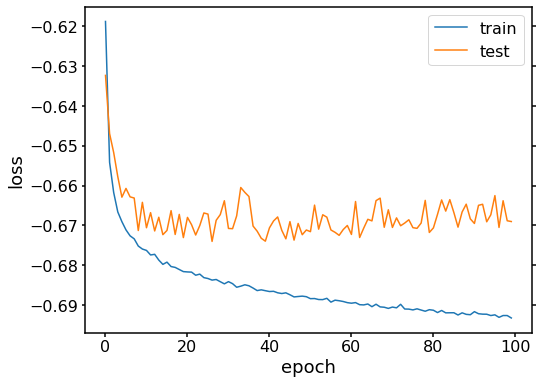

In [11]:
# check losses
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('loss', fontsize=18)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.5)
      ax.spines[axis].set_color('0.0')

ax.legend(fontsize=16, loc='upper right')

plt.savefig("loss.png", dpi=300)

In [12]:
coords_pred_train, max_probs_train = get_model_predictions(model, x_train)
azi_pred_train, zen_pred_train = coords_pred_train[:,0], coords_pred_train[:,1]
azi_true_train, zen_true_train = y_orig_train[:,0], y_orig_train[:,1]

coords_pred_test, max_probs_test = get_model_predictions(model, x_test)
azi_pred_test, zen_pred_test = coords_pred_test[:,0], coords_pred_test[:,1]
azi_true_test, zen_true_test = y_orig_test[:,0], y_orig_test[:,1]

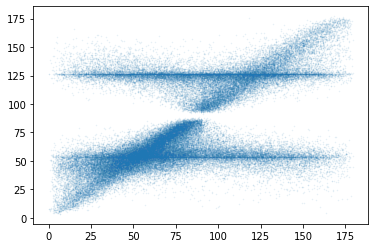

In [13]:
plt.plot(np.rad2deg(zen_true_train), np.rad2deg(zen_pred_train), '.', ms=1, alpha=0.1)

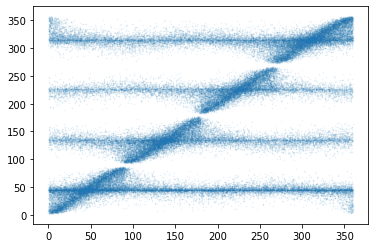

In [14]:
plt.plot(np.rad2deg(azi_true_train), np.rad2deg(azi_pred_train), '.', ms=1, alpha=0.1)

31.360884290862693


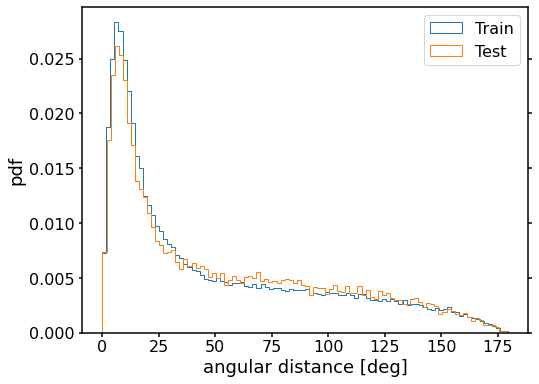

In [31]:
angdiff_train = sphm.angular_dist(coords_pred_train, y_orig_train)
angdiff_test = sphm.angular_dist(coords_pred_test, y_orig_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.hist(np.rad2deg(angdiff_train), bins=100, density=True, histtype="step", label='Train');
ax.hist(np.rad2deg(angdiff_test), bins=100, density=True, histtype="step", label='Test');
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.5)
      ax.spines[axis].set_color('0.0')

ax.set_xlabel('angular distance [deg]', fontsize=18)
ax.set_ylabel('pdf', fontsize=18)
ax.legend(fontsize=16, loc='upper right')
plt.savefig("ang_dist.png", dpi=300)

print(np.median(np.rad2deg(angdiff_train)))

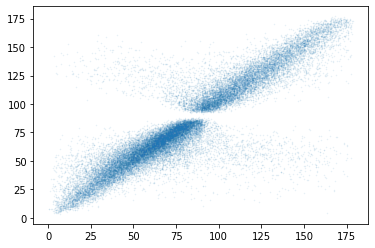

In [32]:
idx_train = max_probs_train > 0.5
plt.plot(np.rad2deg(zen_true_train[idx_train]), np.rad2deg(zen_pred_train[idx_train]), '.', ms=1, alpha=0.1)

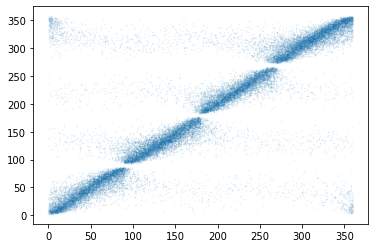

In [33]:
plt.plot(np.rad2deg(azi_true_train[idx_train]), np.rad2deg(azi_pred_train[idx_train]), '.', ms=1, alpha=0.1)

10.498033345956994


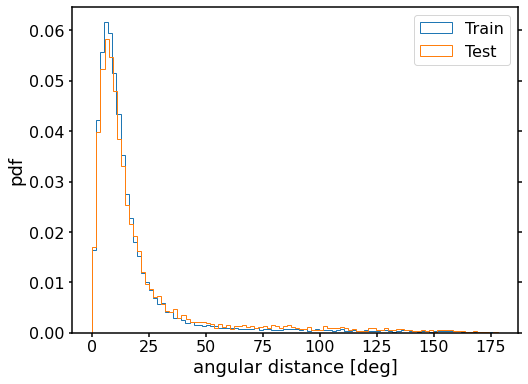

In [34]:
angdiff_train = angdiff_train[idx_train]

idx_test = max_probs_test > 0.5
angdiff_test = angdiff_test[idx_test]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.hist(np.rad2deg(angdiff_train), bins=100, density=True, histtype="step", label='Train');
ax.hist(np.rad2deg(angdiff_test), bins=100, density=True, histtype="step", label='Test');
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.5)
      ax.spines[axis].set_color('0.0')

ax.set_xlabel('angular distance [deg]', fontsize=18)
ax.set_ylabel('pdf', fontsize=18)
ax.legend(fontsize=16, loc='upper right')
plt.savefig("ang_dist.png", dpi=300)

print(np.median(np.rad2deg(angdiff_train)))

In [36]:
print(np.sum(idx_train)/len(idx_train))

0.4161
